In [1]:
import gymnasium as gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as patches
import math
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from agents.random_agent import RandomAgent
from agents.DQN_agent import DQNAgent
from agents.DQN_RND_agent import DQNRNDAgent
from agents.Dyna_agent import DynaAgent

from agents.MLP import QNetwork

from agents.data_processing import *

# Random Agent

In [2]:
seed = 42

# Create env
max_episode_steps=200
env = gym.make('MountainCar-v0', render_mode='rgb_array', max_episode_steps=max_episode_steps)

# Create agent
action_space = np.array([0, 1, 2])
agent = RandomAgent(action_space, seed+1)

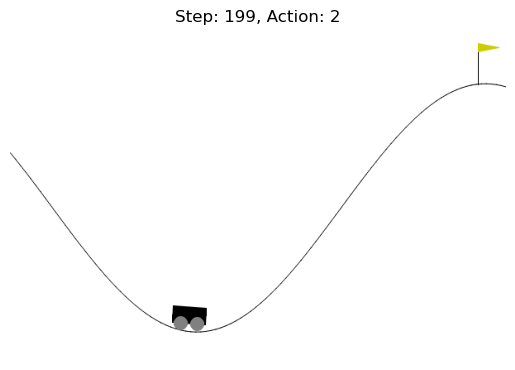

In [3]:
frames = []
actions = []

# Run episode
state, _ = env.reset(seed=101)
done = False
while not done:
    action = agent.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)

    state = next_state
    done = terminated or truncated

    frames.append(env.render())
    actions.append(action)
    
# Replay episode
for i, frame in enumerate(frames):
    clear_output(wait=True)
    plt.imshow(frame)
    plt.title(f"Step: {i}, Action: {actions[i]}")
    plt.axis('off')
    plt.show()

In [4]:
seed = 42

# Create env
max_episode_steps=200
env = gym.make('MountainCar-v0', max_episode_steps=max_episode_steps)

# Create agent
action_space = np.array([0, 1, 2])
agent = RandomAgent(action_space, seed+1)

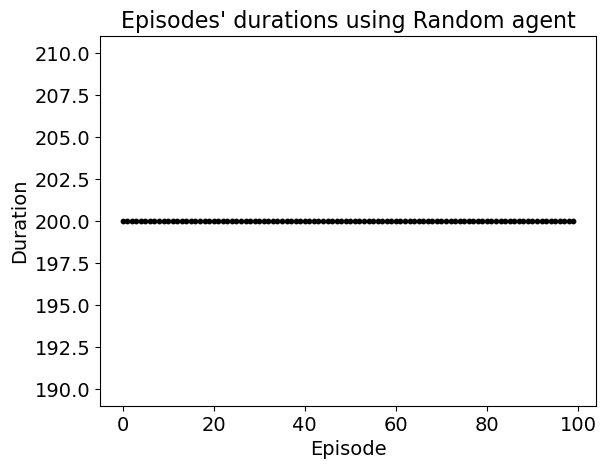

In [5]:
n_episodes = 100

durations = np.zeros(n_episodes, dtype=int)

rng_seed = np.random.default_rng(seed)
for episode in range(n_episodes):
    state, _ = env.reset(seed=rng_seed.integers(2147483647).item())
    done = False
    
    duration = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        agent.observe(state, action, next_state, reward)
        loss = agent.update()

        duration += 1
        done = terminated or truncated
    
    durations[episode] = duration

plt.scatter(range(n_episodes), durations, s=10, c='black')
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' durations using Random agent", fontsize=16)
plt.savefig("plots/A_Random_duration.pdf", transparent=True, bbox_inches="tight")
plt.show()

# DQN Agent - No reward

## Agent training

In [6]:
seed = 105

torch.manual_seed(seed + 2)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed + 3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create env
max_episode_steps=200
env = gym.make('MountainCar-v0', max_episode_steps=max_episode_steps)

# Create agent
action_space = np.array([0, 1, 2])
action_space_size = action_space.size
state_size = 2

# Set up torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Create MLP
hidden_dims = [64] * 2
act = F.sigmoid
Q = QNetwork(state_size, action_space_size, hidden_dims, act=act)

# Setup hyperparameters
eps_max = 0.9
eps_min = 0.05
t_at_capacity = 100000  # number of iterations before reaching eps_min (e^-5 =~ 0)
eps = lambda t : eps_min + (eps_max - eps_min) * math.exp(-t * 5. / t_at_capacity)

gamma = 0.99
buffer_size = 10000
batch_size = 64
start_sampling = 1000

# Setup optimizer
lr = 0.001
weight_decay = 0.01
optimizer = optim.AdamW(Q.parameters(), lr=lr, weight_decay=weight_decay)

agent = DQNAgent(action_space, Q, optimizer,
                 gamma=gamma, eps=eps, buffer_size=buffer_size, batch_size=batch_size, start_sampling=start_sampling,
                 device=device, random_seed=seed)

Running on cuda


In [7]:
n_episodes = 1000

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
losses = np.zeros(n_episodes, dtype=float)
rewards = np.zeros(n_episodes, dtype=float)

rng_seed = np.random.default_rng(seed + 1)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_reward = 0
    episode_loss = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        agent.observe(state, action, next_state, reward)
        loss = agent.update()

        state = next_state
        done = terminated or truncated

        episode_reward += reward
        episode_steps += 1
        episode_loss += loss if loss is not None else 0
    
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, Loss: {episode_loss/episode_steps: .2e}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")
    
    durations[episode] = episode_steps
    losses[episode] = episode_loss/episode_steps
    rewards[episode] = episode_reward

Episode: 0, Reward: -200.0000, Loss:  0.00e+00, Steps: 200, epsilon:  0.8915
Episode: 1, Reward: -200.0000, Loss:  0.00e+00, Steps: 200, epsilon:  0.8832
Episode: 2, Reward: -200.0000, Loss:  0.00e+00, Steps: 200, epsilon:  0.8749
Episode: 3, Reward: -200.0000, Loss:  0.00e+00, Steps: 200, epsilon:  0.8667
Episode: 4, Reward: -200.0000, Loss:  2.65e-03, Steps: 200, epsilon:  0.8585
Episode: 5, Reward: -200.0000, Loss:  6.52e-01, Steps: 200, epsilon:  0.8505
Episode: 6, Reward: -200.0000, Loss:  4.87e-01, Steps: 200, epsilon:  0.8425
Episode: 7, Reward: -200.0000, Loss:  3.50e-01, Steps: 200, epsilon:  0.8346
Episode: 8, Reward: -200.0000, Loss:  2.41e-01, Steps: 200, epsilon:  0.8268
Episode: 9, Reward: -200.0000, Loss:  1.63e-01, Steps: 200, epsilon:  0.8191
Episode: 10, Reward: -200.0000, Loss:  1.07e-01, Steps: 200, epsilon:  0.8115
Episode: 11, Reward: -200.0000, Loss:  6.53e-02, Steps: 200, epsilon:  0.8039
Episode: 12, Reward: -200.0000, Loss:  4.09e-02, Steps: 200, epsilon:  0.7

**OPTIONAL: save results**

In [8]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'reward': rewards,
    'duration': durations,
    'loss': losses
}

df = pd.DataFrame(data)

df.to_csv('results/B_train_DQN_noReward.csv', index=False)

## Plotting

**OPTIONAL: load results**

In [9]:
df = pd.read_csv('results/B_train_DQN_noReward.csv')

n_episodes = len(df.index)

seeds = df['seed'].to_numpy()
initial_xs = df['initial_x'].to_numpy()
rewards = df['reward'].to_numpy()
durations = df['duration'].to_numpy()
losses = df['loss'].to_numpy()

**PLOT: episodes duration**

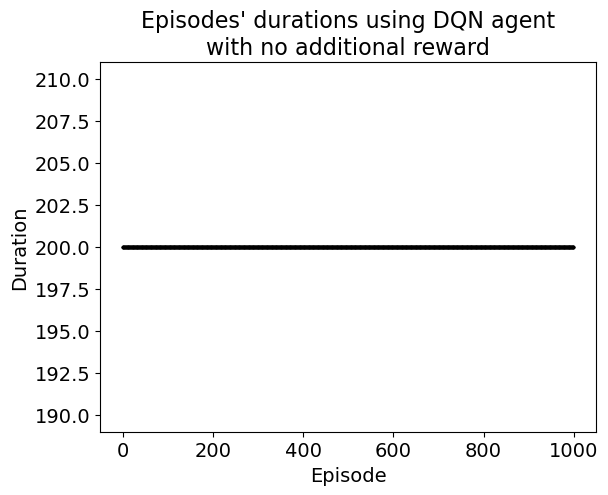

In [10]:
plt.scatter(range(n_episodes), durations, s=3, c='black', rasterized=True)
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' durations using DQN agent\nwith no additional reward", fontsize=16)
plt.savefig("plots/B_DQN_noReward_duration.pdf", format='pdf', transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training loss**

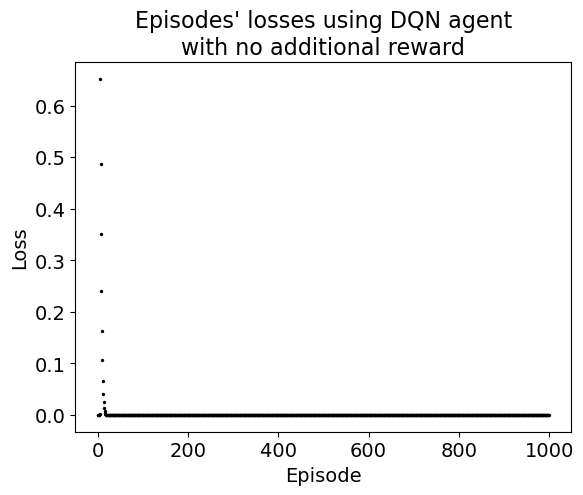

In [11]:
plt.scatter(range(n_episodes), losses, s=2, c='black', rasterized=True)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' losses using DQN agent\nwith no additional reward", fontsize=16)
plt.savefig("plots/B_DQN_noReward_loss.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

# DQN Agent - Heuristic reward

## Agent training

In [12]:
seed = 101

torch.manual_seed(seed + 2)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed + 3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create env
max_episode_steps=200
env = gym.make('MountainCar-v0', max_episode_steps=max_episode_steps)

# Create agent
action_space = np.array([0, 1, 2])
action_space_size = action_space.size
state_size = 2

# Set up torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Create MLP
hidden_dims = [64] * 2
act = F.sigmoid
Q = QNetwork(state_size, action_space_size, hidden_dims, act=act)

# Setup hyperparameters
eps_max = 0.9
eps_min = 0.05
t_at_capacity = 100000  # number of iterations before reaching eps_min (e^-5 =~ 0)
eps = lambda t : eps_min + (eps_max - eps_min) * math.exp(-t * 5. / t_at_capacity)

gamma = 0.99
buffer_size = 10000
batch_size = 64
start_sampling = 1000

# Setup optimizer
lr = 0.001
weight_decay = 0.01
optimizer = optim.AdamW(Q.parameters(), lr=lr, weight_decay=weight_decay)

agent = DQNAgent(action_space, Q, optimizer,
                 gamma=gamma, eps=eps, buffer_size=buffer_size, batch_size=batch_size, start_sampling=start_sampling,
                 device=device, random_seed=seed)

Running on cuda


In [13]:
E = lambda state: 0.5*state[1]**2 + (1./2)*0.0025*np.sin(3*state[0])
heuristic_reward = lambda old_state, new_state: 15_000 * (E(new_state) - E(old_state))

n_episodes = 3000

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
losses = np.zeros(n_episodes, dtype=float)
env_rewards = np.zeros(n_episodes, dtype=float)
heu_rewards = np.zeros(n_episodes, dtype=float)
rewards = np.zeros(n_episodes, dtype=float)

losses_steps = []

rng_seed = np.random.default_rng(seed + 1)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_env_reward = 0
    episode_heu_reward = 0
    episode_reward = 0
    episode_loss = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, env_reward, terminated, truncated, _ = env.step(action)

        heu_reward = heuristic_reward(state, next_state)
        reward = env_reward + heu_reward
        
        agent.observe(state, action, next_state, reward)
        loss = agent.update()

        state = next_state
        done = terminated or truncated

        episode_env_reward += env_reward
        episode_heu_reward += heu_reward
        episode_reward += reward
        episode_steps += 1
        episode_loss += loss if loss is not None else 0

        losses_steps.append(loss if loss is not None else 0)
    
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, Loss: {episode_loss/episode_steps: .2e}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")

    durations[episode] = episode_steps
    losses[episode] = episode_loss/episode_steps
    env_rewards[episode] = episode_env_reward
    heu_rewards[episode] = episode_heu_reward
    rewards[episode] = episode_reward

losses_steps = np.array(losses_steps)

Episode: 0, Reward: -200.3599, Loss:  0.00e+00, Steps: 200, epsilon:  0.8915
Episode: 1, Reward: -197.1446, Loss:  0.00e+00, Steps: 200, epsilon:  0.8832
Episode: 2, Reward: -199.3212, Loss:  0.00e+00, Steps: 200, epsilon:  0.8749
Episode: 3, Reward: -199.9324, Loss:  0.00e+00, Steps: 200, epsilon:  0.8667
Episode: 4, Reward: -196.2268, Loss:  2.74e-03, Steps: 200, epsilon:  0.8585
Episode: 5, Reward: -197.7798, Loss:  5.44e-01, Steps: 200, epsilon:  0.8505
Episode: 6, Reward: -199.4719, Loss:  3.97e-01, Steps: 200, epsilon:  0.8425
Episode: 7, Reward: -198.2675, Loss:  2.76e-01, Steps: 200, epsilon:  0.8346
Episode: 8, Reward: -199.1452, Loss:  1.99e-01, Steps: 200, epsilon:  0.8268
Episode: 9, Reward: -198.7002, Loss:  1.43e-01, Steps: 200, epsilon:  0.8191
Episode: 10, Reward: -199.6164, Loss:  9.70e-02, Steps: 200, epsilon:  0.8115
Episode: 11, Reward: -199.8337, Loss:  6.61e-02, Steps: 200, epsilon:  0.8039
Episode: 12, Reward: -199.8955, Loss:  4.19e-02, Steps: 200, epsilon:  0.7

**OPTIONAL: save results**

In [14]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'env_reward': env_rewards,
    'other_reward': heu_rewards,
    'reward': rewards,
    'duration': durations,
    'loss': losses
}

df = pd.DataFrame(data)

df.to_csv('results/C_train_DQN_heuristic.csv', index=False)

np.save("results/C_train_DQN_heuristic_lossesSteps", losses_steps)

## Plotting

**OPTIONAL: load results**

In [15]:
df = pd.read_csv('results/C_train_DQN_heuristic.csv')

n_episodes = len(df.index)

seeds = df['seed'].to_numpy()
initial_xs = df['initial_x'].to_numpy()
env_rewards = df['env_reward'].to_numpy()
heu_rewards = df['other_reward'].to_numpy()
rewards = df['reward'].to_numpy()
durations = df['duration'].to_numpy()
losses = df['loss'].to_numpy()

losses_steps = np.load("results/C_train_DQN_heuristic_lossesSteps.npy")

**PLOT: episodes duration**

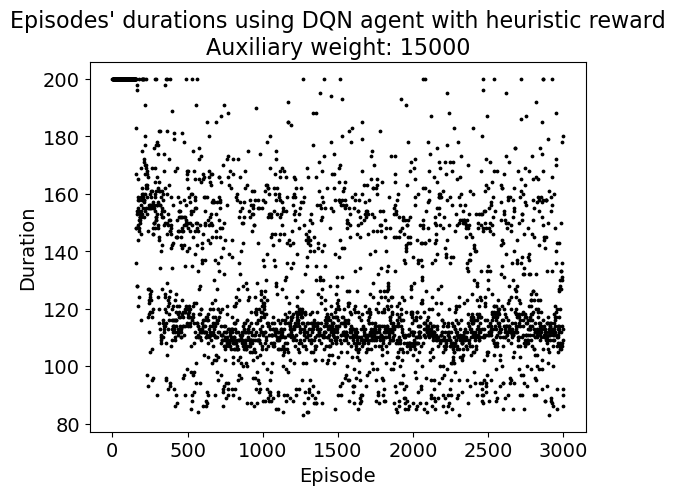

In [16]:
plt.scatter(range(n_episodes), durations, s=3, c='black', rasterized=True)
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' durations using DQN agent with heuristic reward\nAuxiliary weight: 15000", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_duration.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode**

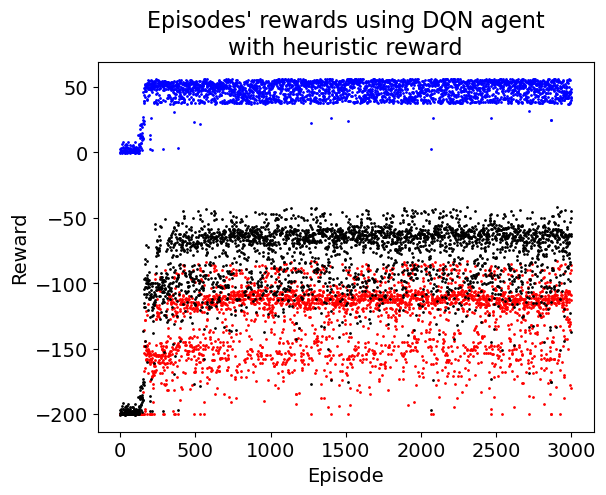

In [17]:
plt.scatter(range(n_episodes), env_rewards, s=1, c='red', label="Environment reward", rasterized=True)
plt.scatter(range(n_episodes), heu_rewards, s=1, c='#0000ff', label="Heuristic reward", rasterized=True)
plt.scatter(range(n_episodes), rewards, s=1, c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' rewards using DQN agent\nwith heuristic reward", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_reward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode (moving average)**

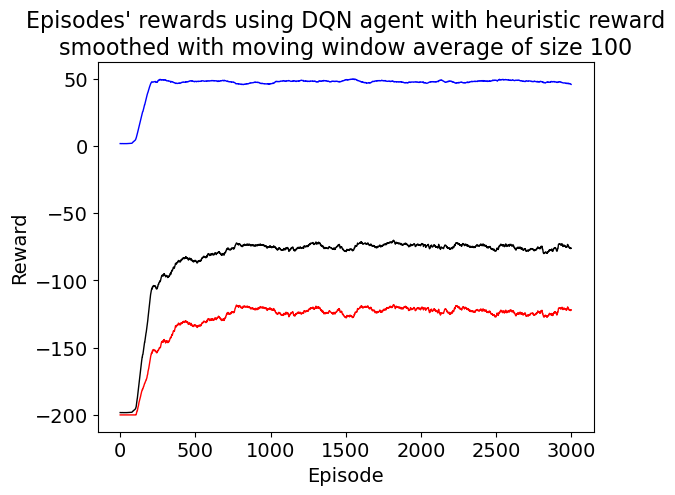

In [18]:
window_size = 100
plot_interval = 1
mask = [plot_interval*i for i in range(n_episodes//plot_interval)] + [n_episodes-1]

plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(env_rewards, window_size)[mask], '-', c='red', label="Environment reward", linewidth=1, rasterized=True)
plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(heu_rewards, window_size)[mask], '-', c='#0000ff', label="Heuristic reward", linewidth=1, rasterized=True)
plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(rewards, window_size)[mask], '-', c='black', label="Total reward", linewidth=1, rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title(f"Episodes' rewards using DQN agent with heuristic reward\nsmoothed with moving window average of size {window_size}", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_reward_avg.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode (normalized)**

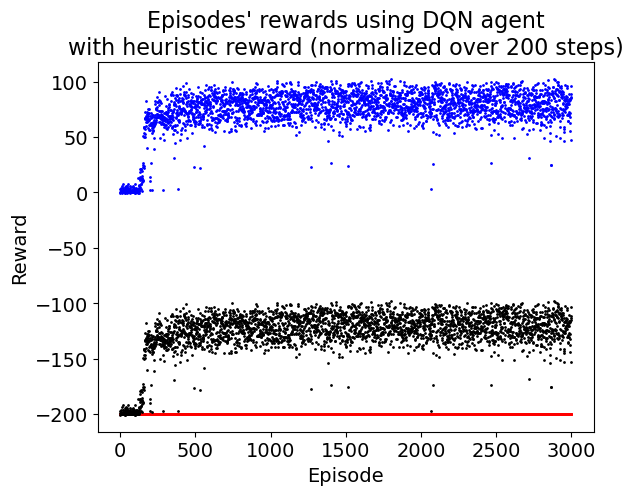

In [19]:
plt.scatter(range(n_episodes), 200*env_rewards/durations, s=1, c='red', label="Environment reward", rasterized=True)
plt.scatter(range(n_episodes), 200*heu_rewards/durations, s=1, c='#0000ff', label="Heuristic reward", rasterized=True)
plt.scatter(range(n_episodes), 200*rewards/durations, s=1, c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' rewards using DQN agent\nwith heuristic reward (normalized over 200 steps)", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_rewardNormalized.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: cumulative reward over episodes**

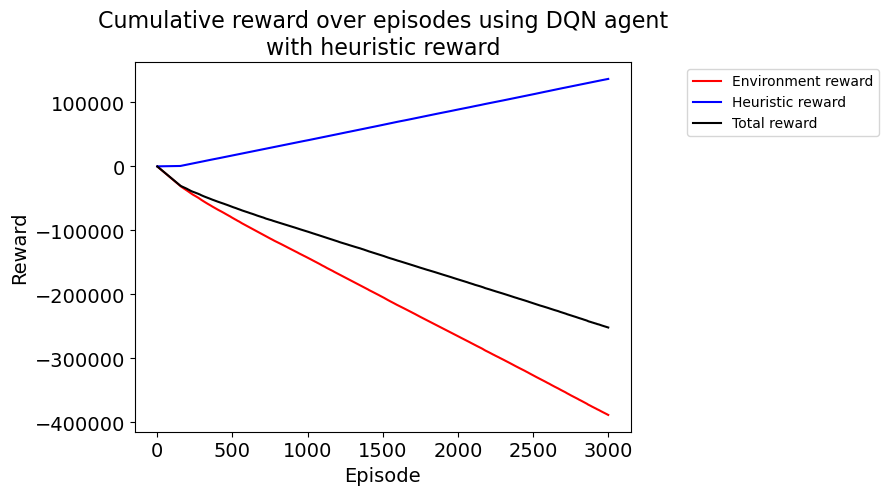

In [20]:
cum_env_rewards = env_rewards.cumsum()
cum_heu_rewards = heu_rewards.cumsum()
cum_rewards = rewards.cumsum()

plt.plot(range(n_episodes), cum_env_rewards, '-', c='red', label="Environment reward", rasterized=True)
plt.plot(range(n_episodes), cum_heu_rewards, '-', c='#0000ff', label="Heuristic reward", rasterized=True)
plt.plot(range(n_episodes), cum_rewards, '-', c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Cumulative reward over episodes using DQN agent\nwith heuristic reward", fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 1), markerscale=3)
plt.savefig("plots/C_DQN_heuristic_cumulativeReward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Cumulative number of successes**

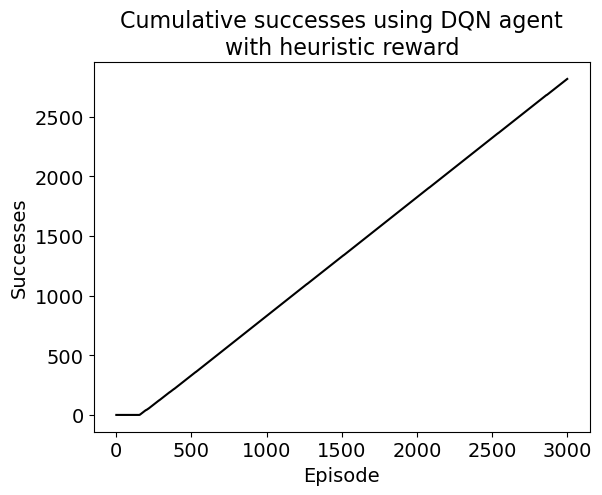

In [21]:
cum_successes = np.array([(1 if d < 200 else 0) for d in durations]).cumsum()

plt.plot(range(n_episodes), cum_successes, '-', c='black', rasterized=True)
plt.ylabel("Successes", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Cumulative successes using DQN agent\nwith heuristic reward", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_cumulativeSuccesses.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training loss**

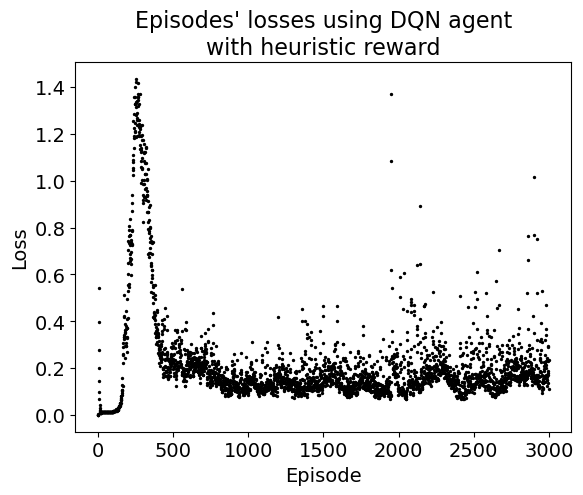

In [22]:
plt.scatter(range(n_episodes), losses, s=2, c='black', rasterized=True)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' losses using DQN agent\nwith heuristic reward", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_loss.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training loss step-by-step**

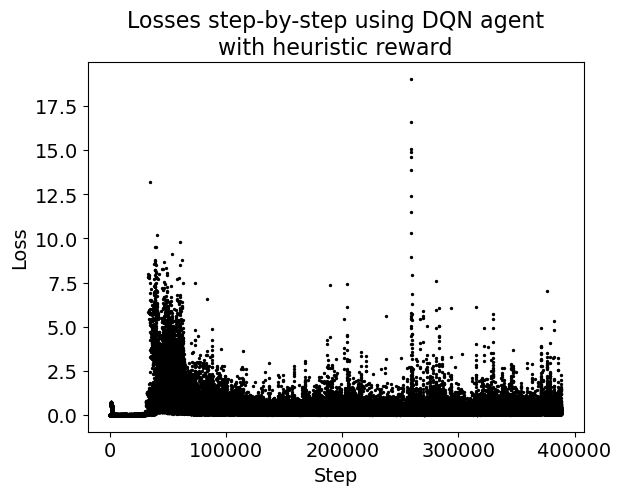

In [23]:
plt.scatter(range(losses_steps.size), losses_steps, s=2, c='black', rasterized=True)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Step", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Losses step-by-step using DQN agent\nwith heuristic reward", fontsize=16)
plt.savefig("plots/C_DQN_heuristic_lossStep.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

## Agent testing

In [24]:
seed = 42

E = lambda state: 0.5*state[1]**2 + (1./2)*0.0025*np.sin(3*state[0])
heuristic_reward = lambda old_state, new_state: 15_000 * (E(new_state) - E(old_state))

n_episodes = 1000

agent.eps = 0

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
env_rewards = np.zeros(n_episodes, dtype=float)
heu_rewards = np.zeros(n_episodes, dtype=float)
rewards = np.zeros(n_episodes, dtype=float)

rng_seed = np.random.default_rng(seed)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_env_reward = 0
    episode_heu_reward = 0
    episode_reward = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, env_reward, terminated, truncated, _ = env.step(action)

        heu_reward = heuristic_reward(state, next_state)
        reward = env_reward + heu_reward
        
        agent.observe(state, action, next_state, reward)
        # loss = agent.update()

        state = next_state
        done = terminated or truncated

        episode_env_reward += env_reward
        episode_heu_reward += heu_reward
        episode_reward += reward
        episode_steps += 1
        episode_loss += loss if loss is not None else 0
    
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")
    
    durations[episode] = episode_steps
    env_rewards[episode] = episode_env_reward
    heu_rewards[episode] = episode_heu_reward
    rewards[episode] = episode_reward

Episode: 0, Reward: -47.7554, Steps: 88, epsilon:  0.0000
Episode: 1, Reward: -56.9157, Steps: 106, epsilon:  0.0000
Episode: 2, Reward: -55.7178, Steps: 107, epsilon:  0.0000
Episode: 3, Reward: -92.7986, Steps: 149, epsilon:  0.0000
Episode: 4, Reward: -95.8463, Steps: 152, epsilon:  0.0000
Episode: 5, Reward: -51.0390, Steps: 91, epsilon:  0.0000
Episode: 6, Reward: -54.6510, Steps: 94, epsilon:  0.0000
Episode: 7, Reward: -55.2275, Steps: 107, epsilon:  0.0000
Episode: 8, Reward: -52.5292, Steps: 92, epsilon:  0.0000
Episode: 9, Reward: -90.8080, Steps: 147, epsilon:  0.0000
Episode: 10, Reward: -55.0603, Steps: 107, epsilon:  0.0000
Episode: 11, Reward: -49.1432, Steps: 89, epsilon:  0.0000
Episode: 12, Reward: -56.7945, Steps: 106, epsilon:  0.0000
Episode: 13, Reward: -55.2458, Steps: 107, epsilon:  0.0000
Episode: 14, Reward: -56.4632, Steps: 107, epsilon:  0.0000
Episode: 15, Reward: -45.1864, Steps: 86, epsilon:  0.0000
Episode: 16, Reward: -45.0586, Steps: 86, epsilon:  0.00

**Save results**

In [25]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'env_reward': env_rewards,
    'other_reward': heu_rewards,
    'reward': rewards,
    'duration': durations
}

df = pd.DataFrame(data)

df.to_csv('results/C_test_DQN_heuristic.csv', index=False)

# DQN Agent - RND reward

## Agent training

In [26]:
seed = 105

torch.manual_seed(seed + 2)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed + 3)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create env
max_episode_steps=200
env = gym.make('MountainCar-v0', max_episode_steps=max_episode_steps)

# Create agent
action_space = np.array([0, 1, 2])
action_space_size = action_space.size
state_size = 2

# Set up torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

# Create MLP
hidden_dims = [64] * 2
act = F.sigmoid
Q = QNetwork(state_size, action_space_size, hidden_dims, act=act)

# Setup hyperparameters
eps_max = 0.9
eps_min = 0.05
t_at_capacity = 100000  # number of iterations before reaching eps_min (e^-5 =~ 0)
eps = lambda t : eps_min + (eps_max - eps_min) * math.exp(-t * 5. / t_at_capacity)

gamma = 0.99
buffer_size = 10000
batch_size = 64
start_sampling = 1000

# Create RND networks
hidden_dims_RND = [64] 
act = F.relu
predictor = QNetwork(state_size, 1, hidden_dims_RND, act=act)
target = QNetwork(state_size, 1, hidden_dims_RND, act=act)

# Setup RND hyperparameters
reward_factor = 0.2
start_RND_reward = 1000

# Setup optimizers
lr = 1e-3
lr_RND = 1e-3
weight_decay = 0.01
weight_decay_RND = 0.01
optimizer = optim.AdamW(Q.parameters(), lr=lr, weight_decay=weight_decay)
optimizer_RND = optim.AdamW(predictor.parameters(), lr=lr_RND, weight_decay=weight_decay_RND)

agent = DQNRNDAgent(action_space, Q, predictor, target, optimizer, optimizer_RND,
                  gamma=gamma, eps=eps, buffer_size=buffer_size, batch_size=batch_size, start_sampling=start_sampling, 
                  reward_factor=reward_factor, start_RND_reward=start_RND_reward,
                  device=device, random_seed=seed)

Running on cuda


In [27]:
n_episodes = 3000

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
losses = np.zeros(n_episodes, dtype=float)
losses_RND = np.zeros(n_episodes, dtype=float)
env_rewards = np.zeros(n_episodes, dtype=float)
RND_rewards = np.zeros(n_episodes, dtype=float)
rewards = np.zeros(n_episodes, dtype=float)

losses_steps = []
losses_steps_RND = []

rng_seed = np.random.default_rng(seed + 1)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_env_reward = 0
    episode_RND_reward = 0
    episode_reward = 0
    episode_loss = 0
    episode_loss_RND = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, env_reward, terminated, truncated, _ = env.step(action)
                
        RND_reward = agent.observe(state, action, next_state, env_reward)
        loss, loss_RND = agent.update()

        state = next_state
        done = terminated or truncated

        episode_env_reward += env_reward
        episode_RND_reward += RND_reward
        episode_reward += env_reward + RND_reward
        episode_steps += 1
        episode_loss += loss if loss is not None else 0
        episode_loss_RND += loss_RND if loss_RND is not None else 0

        losses_steps.append(loss if loss is not None else 0)
        losses_steps_RND.append(loss_RND if loss_RND is not None else 0)
    
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, Loss: {episode_loss/episode_steps: .2e}, {episode_loss_RND: .2e}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")

    durations[episode] = episode_steps
    losses[episode] = episode_loss/episode_steps
    losses_RND[episode] = episode_loss_RND/episode_steps
    env_rewards[episode] = episode_env_reward
    RND_rewards[episode] = episode_RND_reward
    rewards[episode] = episode_reward

losses_steps = np.array(losses_steps)
losses_steps_RND = np.array(losses_steps_RND)

Episode: 0, Reward: -200.0000, Loss:  0.00e+00,  0.00e+00, Steps: 200, epsilon:  0.8915
Episode: 1, Reward: -200.0000, Loss:  0.00e+00,  0.00e+00, Steps: 200, epsilon:  0.8832
Episode: 2, Reward: -200.0000, Loss:  0.00e+00,  0.00e+00, Steps: 200, epsilon:  0.8749
Episode: 3, Reward: -200.0000, Loss:  0.00e+00,  0.00e+00, Steps: 200, epsilon:  0.8667
Episode: 4, Reward: -200.0000, Loss:  2.65e-03,  2.08e-03, Steps: 200, epsilon:  0.8585
Episode: 5, Reward: -319.7443, Loss:  6.68e-01,  2.57e-02, Steps: 200, epsilon:  0.8505
Episode: 6, Reward: -249.4789, Loss:  5.19e-01,  1.48e-04, Steps: 200, epsilon:  0.8425
Episode: 7, Reward: -311.0871, Loss:  3.85e-01,  1.06e-04, Steps: 200, epsilon:  0.8346
Episode: 8, Reward: -297.9015, Loss:  2.75e-01,  6.24e-05, Steps: 200, epsilon:  0.8268
Episode: 9, Reward: -285.0969, Loss:  1.93e-01,  5.19e-05, Steps: 200, epsilon:  0.8191
Episode: 10, Reward: -292.2588, Loss:  1.34e-01,  3.92e-05, Steps: 200, epsilon:  0.8115
Episode: 11, Reward: -288.9817,

**OPTIONAL: save results**

In [28]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'env_reward': env_rewards,
    'other_reward': RND_rewards,
    'reward': rewards,
    'duration': durations,
    'loss': losses,
    'loss_RND': losses_RND
}

df = pd.DataFrame(data)

df.to_csv('results/D_train_DQN_RND.csv', index=False)

np.save("results/D_train_DQN_RND_lossesSteps", losses_steps)
np.save("results/D_train_DQN_RND_lossesStepsRND", losses_steps_RND)

## Plotting

**OPTIONAL: load results**

In [29]:
df = pd.read_csv('results/D_train_DQN_RND.csv')

n_episodes = len(df.index)

seeds = df['seed'].to_numpy()
initial_xs = df['initial_x'].to_numpy()
env_rewards = df['env_reward'].to_numpy()
RND_rewards = df['other_reward'].to_numpy()
rewards = df['reward'].to_numpy()
durations = df['duration'].to_numpy()
losses = df['loss'].to_numpy()
losses_RND = df['loss_RND'].to_numpy()

losses_steps = np.load("results/D_train_DQN_RND_lossesSteps.npy")
losses_steps_RND = np.load("results/D_train_DQN_RND_lossesStepsRND.npy")

**PLOT: episodes duration**

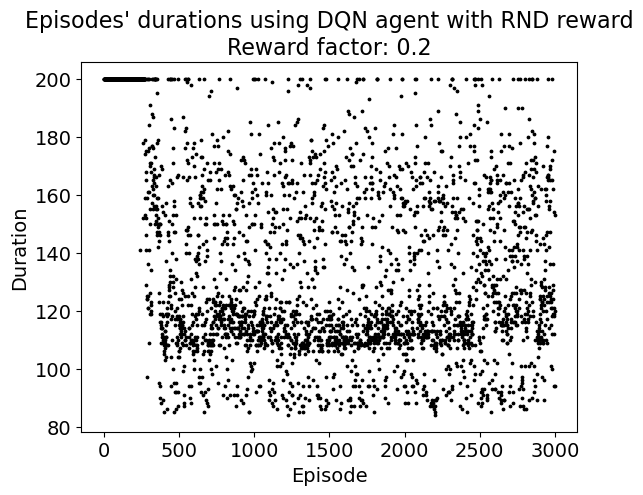

In [30]:
plt.scatter(range(n_episodes), durations, s=3, c='black', rasterized=True)
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' durations using DQN agent with RND reward\nReward factor: 0.2", fontsize=16)
plt.savefig("plots/D_DQN_RND_duration.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode**

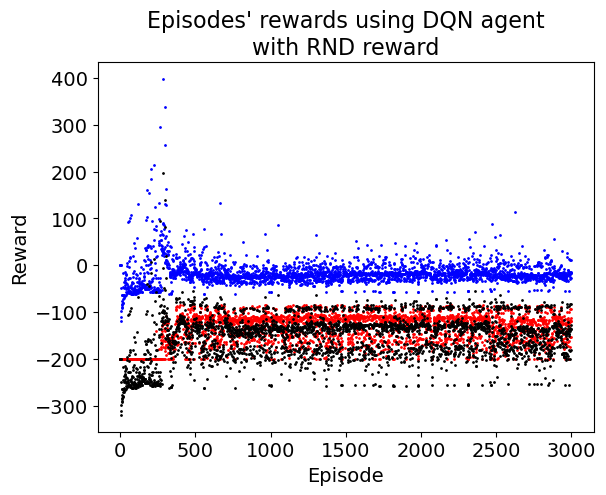

In [31]:
plt.scatter(range(n_episodes), env_rewards, s=1, c='red', label="Environment reward", rasterized=True)
plt.scatter(range(n_episodes), RND_rewards, s=1, c='#0000ff', label="RND reward", rasterized=True)
plt.scatter(range(n_episodes), rewards, s=1, c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' rewards using DQN agent\nwith RND reward", fontsize=16)
plt.savefig("plots/D_DQN_RND_reward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode (moving average)**

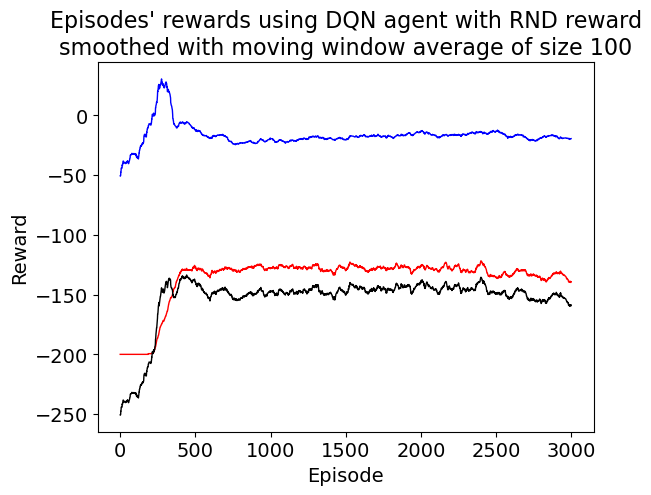

In [32]:
window_size = 100
plot_interval = 1
mask = [plot_interval*i for i in range(n_episodes//plot_interval)] + [n_episodes-1]

plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(env_rewards, window_size)[mask], '-', c='red', label="Environment reward", linewidth=1, rasterized=True)
plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(RND_rewards, window_size)[mask], '-', c='#0000ff', label="Heuristic reward", linewidth=1, rasterized=True)
plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(rewards, window_size)[mask], '-', c='black', label="Total reward", linewidth=1, rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title(f"Episodes' rewards using DQN agent with RND reward\nsmoothed with moving window average of size {window_size}", fontsize=16)
plt.savefig("plots/D_DQN_RND_reward_avg.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode (normalized)**

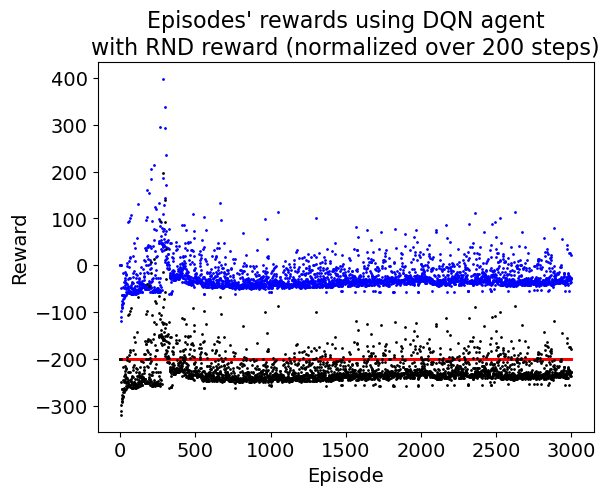

In [33]:
plt.scatter(range(n_episodes), 200*env_rewards/durations, s=1, c='red', label="Environment reward", rasterized=True)
plt.scatter(range(n_episodes), 200*RND_rewards/durations, s=1, c='#0000ff', label="RND reward", rasterized=True)
plt.scatter(range(n_episodes), 200*rewards/durations, s=1, c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' rewards using DQN agent\nwith RND reward (normalized over 200 steps)", fontsize=16)
plt.savefig("plots/D_DQN_RND_rewardNormalized.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: cumulative reward over episodes**

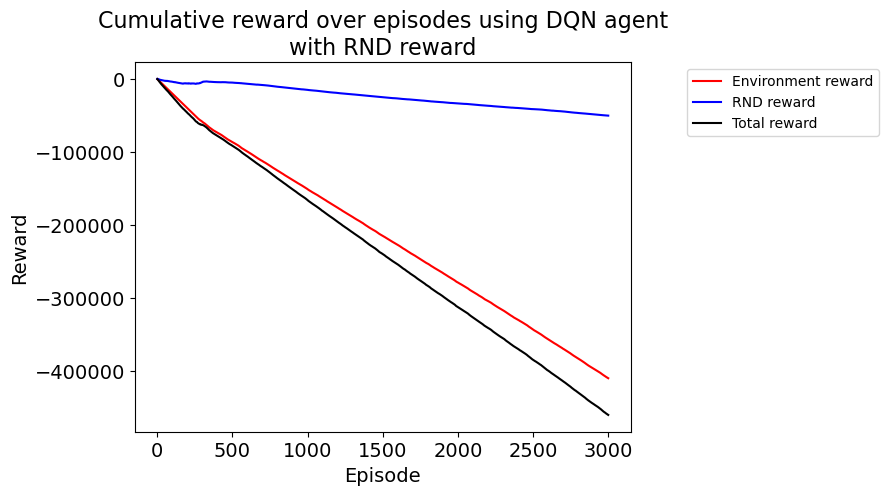

In [34]:
cum_env_rewards = env_rewards.cumsum()
cum_RND_rewards = RND_rewards.cumsum()
cum_rewards = rewards.cumsum()

plt.plot(range(n_episodes), cum_env_rewards, '-', c='red', label="Environment reward", rasterized=True)
plt.plot(range(n_episodes), cum_RND_rewards, '-', c='#0000ff', label="RND reward", rasterized=True)
plt.plot(range(n_episodes), cum_rewards, '-', c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Cumulative reward over episodes using DQN agent\nwith RND reward", fontsize=16)
plt.legend(bbox_to_anchor=(1.1, 1), markerscale=3)
plt.savefig("plots/D_DQN_RND_cumulativeReward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Cumulative number of successes**

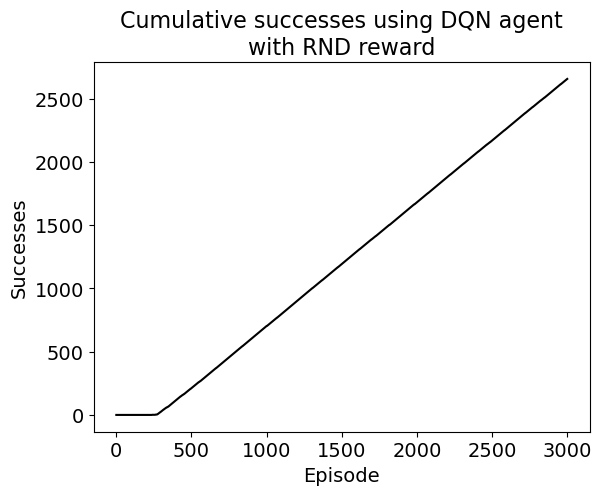

In [35]:
cum_successes = np.array([(1 if d < 200 else 0) for d in durations]).cumsum()

plt.plot(range(n_episodes), cum_successes, '-', c='black', rasterized=True)
plt.ylabel("Successes", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Cumulative successes using DQN agent\nwith RND reward", fontsize=16)
plt.savefig("plots/D_DQN_RND_cumulativeSuccesses.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training loss**

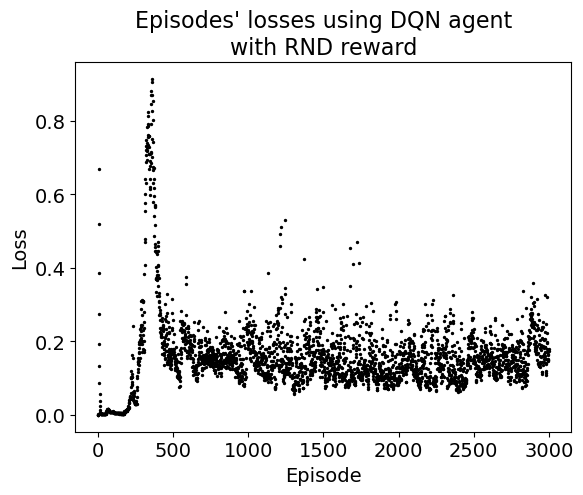

In [36]:
plt.scatter(range(n_episodes), losses, s=2, c='black', rasterized=True)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' losses using DQN agent\nwith RND reward", fontsize=16)
plt.savefig("plots/D_DQN_RND_loss.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training loss step-by-step**

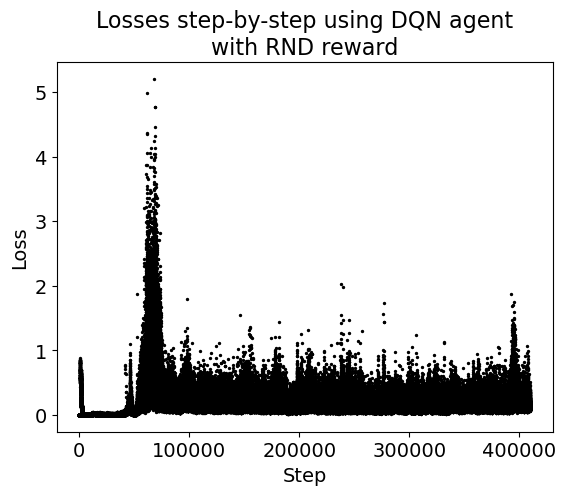

In [37]:
plt.scatter(range(losses_steps.size), losses_steps, s=2, c='black', rasterized=True)
plt.ylabel("Loss", fontsize=14)
plt.xlabel("Step", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Losses step-by-step using DQN agent\nwith RND reward", fontsize=16)
plt.savefig("plots/D_DQN_RND_lossStep.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

## Agent testing

In [38]:
seed = 42

n_episodes = 1000

agent.eps = 0

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
env_rewards = np.zeros(n_episodes, dtype=float)
RND_rewards = np.zeros(n_episodes, dtype=float)
rewards = np.zeros(n_episodes, dtype=float)

rng_seed = np.random.default_rng(seed)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_env_reward = 0
    episode_RND_reward = 0
    episode_reward = 0
    episode_loss = 0
    episode_loss_RND = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, env_reward, terminated, truncated, _ = env.step(action)
                
        RND_reward = agent.observe(state, action, next_state, env_reward)
        # loss, loss_RND = agent.update()

        state = next_state
        done = terminated or truncated

        episode_env_reward += env_reward
        episode_RND_reward += RND_reward
        episode_reward += env_reward + RND_reward
        episode_steps += 1
    
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")

    durations[episode] = episode_steps
    env_rewards[episode] = episode_env_reward
    RND_rewards[episode] = episode_RND_reward
    rewards[episode] = episode_reward

Episode: 0, Reward: -256.5272, Steps: 200, epsilon:  0.0000
Episode: 1, Reward: -126.5448, Steps: 109, epsilon:  0.0000
Episode: 2, Reward: -126.2143, Steps: 109, epsilon:  0.0000
Episode: 3, Reward: -128.8845, Steps: 111, epsilon:  0.0000
Episode: 4, Reward: -132.1914, Steps: 114, epsilon:  0.0000
Episode: 5, Reward: -147.8795, Steps: 126, epsilon:  0.0000
Episode: 6, Reward: -141.0441, Steps: 122, epsilon:  0.0000
Episode: 7, Reward: -127.2800, Steps: 109, epsilon:  0.0000
Episode: 8, Reward: -143.2285, Steps: 124, epsilon:  0.0000
Episode: 9, Reward: -127.5023, Steps: 110, epsilon:  0.0000
Episode: 10, Reward: -125.9572, Steps: 108, epsilon:  0.0000
Episode: 11, Reward: -256.4802, Steps: 200, epsilon:  0.0000
Episode: 12, Reward: -126.6943, Steps: 109, epsilon:  0.0000
Episode: 13, Reward: -127.2021, Steps: 109, epsilon:  0.0000
Episode: 14, Reward: -126.1553, Steps: 109, epsilon:  0.0000
Episode: 15, Reward: -256.4843, Steps: 200, epsilon:  0.0000
Episode: 16, Reward: -256.4721, St

**Save results**

In [39]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'env_reward': env_rewards,
    'other_reward': RND_rewards,
    'reward': rewards,
    'duration': durations
}

df = pd.DataFrame(data)

df.to_csv('results/D_test_DQN_RND.csv', index=False)

# Dyna Agent

In [40]:
seed = 103

# Create env
max_episode_steps=200
env = gym.make('MountainCar-v0', max_episode_steps=max_episode_steps)

# Create agent
action_space = np.array([0, 1, 2])
state_space = np.array([[-1.2, -0.07], [0.6, 0.07]])

# Setup hyperparameters
eps_max = 0.9
eps_min = 0.05
t_at_capacity = 100000  # number of iterations before reaching eps_min (e^-5 =~ 0)
eps = lambda t : eps_min + (eps_max - eps_min) * math.exp(-t * 5. / t_at_capacity)

discr_step = np.array([0.025, 0.005])
k = 20

gamma = 0.99
buffer_size = 10000
batch_size = 64
start_sampling = 1000

agent = DynaAgent(action_space, state_space=state_space, discr_step=discr_step, k=k,
                   gamma=gamma, eps=eps, buffer_size=buffer_size, start_sampling=start_sampling, random_seed=seed)

In [41]:
n_episodes = 3000

partial_times = np.array([100, 200, 350, 500, 1000, 2000], dtype=int)
partial_times_set = set(partial_times)
partial_max_Q_values = np.empty((partial_times.size, agent.num_states_vect[1], agent.num_states_vect[0]), dtype=float)
partial_visited_states = np.empty((partial_times.size, agent.num_states_vect[1], agent.num_states_vect[0]), dtype=bool)
partial_counter = 0

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
q_updates = np.zeros(n_episodes, dtype=float)
rewards = np.zeros(n_episodes, dtype=float)

q_updates_steps = []

rng_seed = np.random.default_rng(seed+1)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_reward = 0
    episode_q_update = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        agent.observe(state, action, next_state, reward)
        q_update = agent.update(state, action, next_state, reward)

        state = next_state
        done = terminated or truncated

        episode_reward += reward
        episode_steps += 1
        episode_q_update += q_update

        q_updates_steps.append(q_update)
        
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, q_update: {episode_q_update/episode_steps: .2e}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")

    durations[episode] = episode_steps
    q_updates[episode] = episode_q_update
    rewards[episode] = episode_reward

    if (episode+1) in partial_times_set:
        partial_max_Q_values[partial_counter] = np.max(agent.Q, axis=1).reshape((agent.num_states_vect[0], agent.num_states_vect[1])).T
        partial_visited_states[partial_counter] = (np.sum(agent.state_action_counter, axis=1) > 0).astype(bool).reshape((agent.num_states_vect[0], agent.num_states_vect[1])).T
        partial_counter += 1

q_updates_steps = np.array(q_updates_steps)

max_Q_values = np.max(agent.Q, axis=1).reshape((agent.num_states_vect[0], agent.num_states_vect[1])).T
visited_states = (np.sum(agent.state_action_counter, axis=1) > 0).astype(bool).reshape((agent.num_states_vect[0], agent.num_states_vect[1])).T

Episode: 0, Reward: -200.0000, q_update: -6.67e-01, Steps: 200, epsilon:  0.8915
Episode: 1, Reward: -200.0000, q_update: -5.98e-01, Steps: 200, epsilon:  0.8832
Episode: 2, Reward: -200.0000, q_update: -6.32e-01, Steps: 200, epsilon:  0.8749
Episode: 3, Reward: -200.0000, q_update: -5.98e-01, Steps: 200, epsilon:  0.8667
Episode: 4, Reward: -200.0000, q_update: -5.27e-01, Steps: 200, epsilon:  0.8585
Episode: 5, Reward: -200.0000, q_update: -3.96e-01, Steps: 200, epsilon:  0.8505
Episode: 6, Reward: -200.0000, q_update: -3.02e-01, Steps: 200, epsilon:  0.8425
Episode: 7, Reward: -200.0000, q_update: -1.27e-01, Steps: 200, epsilon:  0.8346
Episode: 8, Reward: -200.0000, q_update: -1.29e-01, Steps: 200, epsilon:  0.8268
Episode: 9, Reward: -200.0000, q_update: -1.21e-01, Steps: 200, epsilon:  0.8191
Episode: 10, Reward: -200.0000, q_update: -6.93e-01, Steps: 200, epsilon:  0.8115
Episode: 11, Reward: -200.0000, q_update: -5.44e-01, Steps: 200, epsilon:  0.8039
Episode: 12, Reward: -200.

**OPTIONAL: save results**

In [42]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'reward': rewards,
    'duration': durations,
    'q_update': q_updates
}

df = pd.DataFrame(data)

df.to_csv('results/E_train_Dyna.csv', index=False)

np.save("results/E_q_updates_steps_Dyna", q_updates_steps)

np.save("results/E_max_Q_values_Dyna", max_Q_values)
np.save("results/E_visited_states_Dyna", visited_states)

np.save("results/E_partial_times_Dyna", partial_times)
np.save("results/E_partial_max_Q_values_Dyna", partial_max_Q_values)
np.save("results/E_partial_visited_states_Dyna", partial_visited_states)

## Plotting

**OPTIONAL: load results**

In [43]:
df = pd.read_csv('results/E_train_Dyna.csv')

n_episodes = len(df.index)

seeds = df['seed'].to_numpy()
initial_xs = df['initial_x'].to_numpy()
rewards = df['reward'].to_numpy()
durations = df['duration'].to_numpy()
q_updates = df['q_update'].to_numpy()

q_updates_steps = np.load("results/E_q_updates_steps_Dyna.npy")

max_Q_values = np.load("results/E_max_Q_values_Dyna.npy")
visited_states = np.load("results/E_visited_states_Dyna.npy")

partial_times = np.load("results/E_partial_times_Dyna.npy")
partial_max_Q_values = np.load("results/E_partial_max_Q_values_Dyna.npy")
partial_visited_states = np.load("results/E_partial_visited_states_Dyna.npy")

**PLOT: episodes duration**

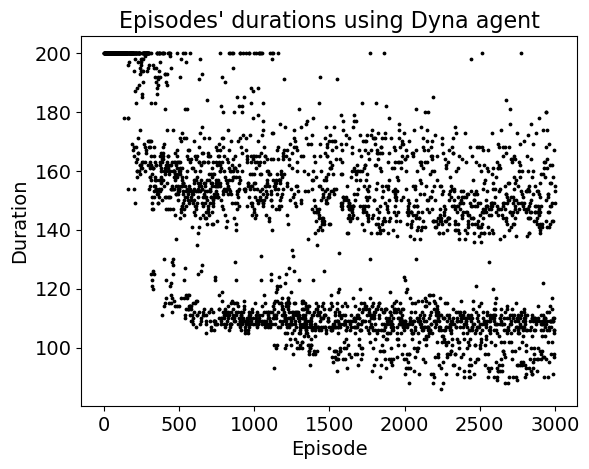

In [44]:
plt.scatter(range(n_episodes), durations, s=3, c='black', rasterized=True)
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' durations using Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_duration.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: episodes duration (colored)**

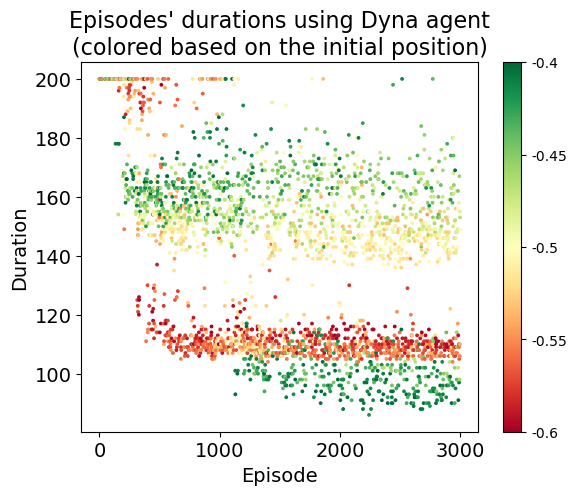

In [45]:
tt = (initial_xs+0.6)/0.2

scatter = plt.scatter(range(n_episodes), durations, s=3, c=tt, cmap='RdYlGn', rasterized=True)

plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episodes' durations using Dyna agent\n(colored based on the initial position)", fontsize=16)

norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=norm)
sm.set_array(tt)

cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels([-0.6, -0.55, -0.5, -0.45, -0.40])

plt.savefig("plots/E_Dyna_duration_colored.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: accumulated reward per episode**

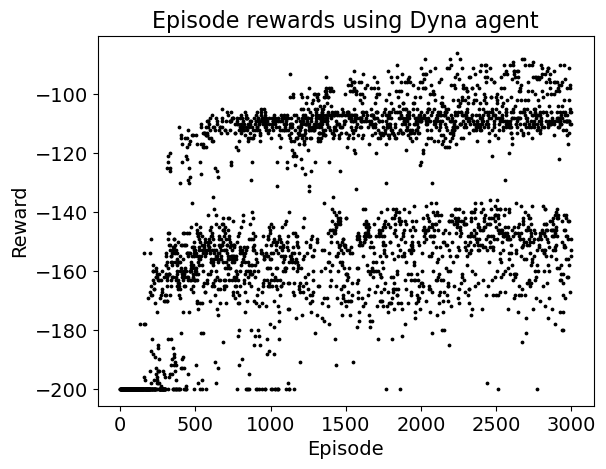

In [46]:
plt.scatter(range(n_episodes), rewards, s=3, c='black', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episode rewards using Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_reward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: cumulative reward over episodes**

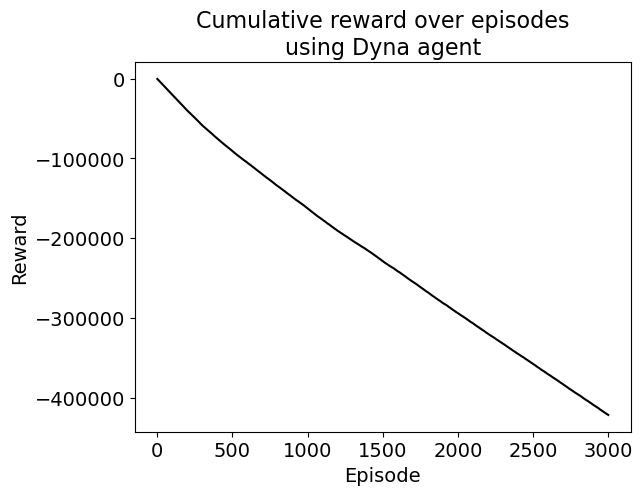

In [47]:
cum_rewards = rewards.cumsum()

plt.plot(range(n_episodes), cum_rewards, '-', c='black', rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Cumulative reward over episodes\nusing Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_cumulativeReward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Cumulative number of successes**

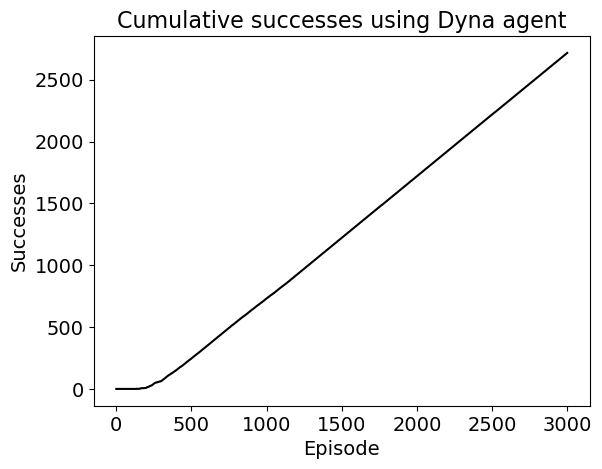

In [48]:
cum_successes = np.array([(1 if d < 200 else 0) for d in durations]).cumsum()

plt.plot(range(n_episodes), cum_successes, '-', c='black', rasterized=True)
plt.ylabel("Successes", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Cumulative successes using Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_cumulativeSuccesses.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training q-update**

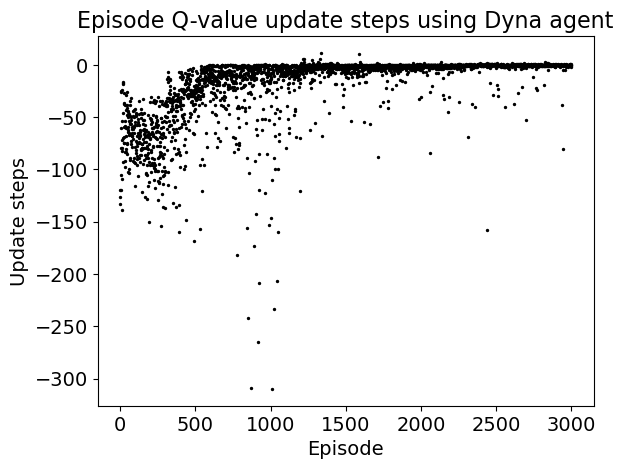

In [49]:
plt.scatter(range(n_episodes), q_updates, s = 2, c='black', rasterized=True)
plt.ylabel("Update steps", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Episode Q-value update steps using Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_update.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: Training q-update step-by-step**

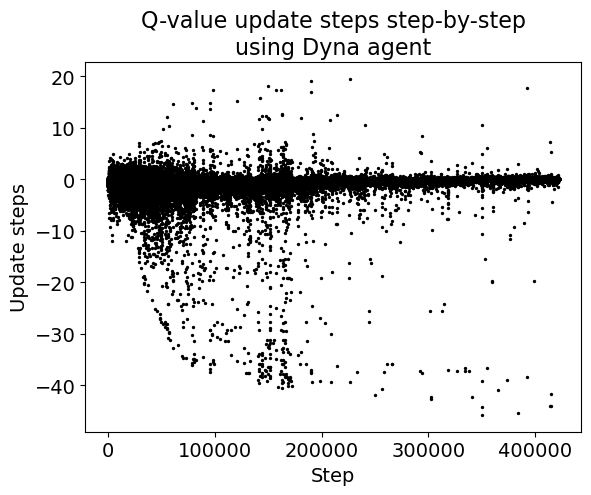

In [50]:
plt.scatter(range(q_updates_steps.size), q_updates_steps, s=2, c='black', rasterized=True)
plt.ylabel("Update steps", fontsize=14)
plt.xlabel("Step", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Q-value update steps step-by-step\nusing Dyna agent", fontsize=16)
plt.savefig("plots/E_Dyna_updateStep.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: max Q-values**

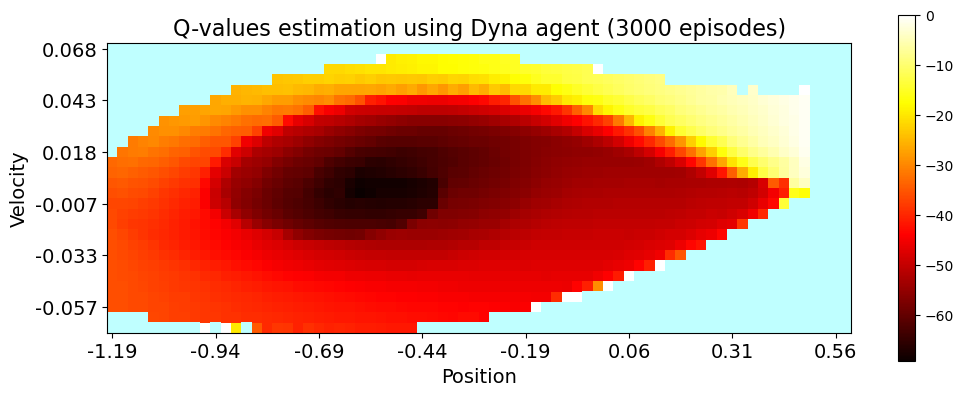

In [51]:
state_space = np.array([[-1.2, -0.07], [0.6, 0.07]])
discr_step = np.array([0.025, 0.005])
num_states_vect = np.round(np.diff(state_space, axis=0).squeeze(axis=0) / discr_step).astype(int)

def index_to_x(i):
    return state_space[0,0] + i*discr_step[0] + discr_step[0]/2
def index_to_v(j):
    return state_space[0,1] + j*discr_step[1] + discr_step[1]/2

def plot_q_values_heatmap(q_values, visited, title = 'Q-values estimation using Dyna agent (3000 episodes)', print_colorbar = True, fontsz = 16):
    fig, ax = plt.subplots(figsize=(12, 4.5))
    
    q_values_flipped = np.flipud(q_values)
    visited_flipped = np.flipud(visited)
    
    cax = ax.imshow(q_values_flipped, cmap='hot', interpolation='nearest', vmin=np.min(max_Q_values), vmax=np.max(max_Q_values))
    if print_colorbar:
        fig.colorbar(cax)
    ax.set_title(title, fontsize=fontsz)
    ax.set_aspect('equal')
    ax.set_xlabel('Position', fontsize=14)
    ax.set_ylabel('Velocity', fontsize=14)
    ax.tick_params(axis='both', labelsize=14)
    
    xticks = np.array([0,10,20,30,40,50,60,70], dtype=int)
    x_labels = index_to_x(xticks.astype(float))
    yticks = np.array([0,5,10,15,20,25], dtype=int)
    y_labels = -index_to_v(yticks.astype(float))
    
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{label:.2f}' for label in x_labels])
    ax.set_yticks(yticks)
    ax.set_yticklabels([f'{label:.3f}' for label in y_labels])
    
    for (i, j), value in np.ndenumerate(visited_flipped):
        if not value:
            rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=0, edgecolor='none', facecolor='#bfffff', rasterized=True)
            ax.add_patch(rect)

plot_q_values_heatmap(max_Q_values, visited_states)
plt.savefig("plots/E_Dyna_Q_values_heatmap.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**Generate interesting trajectories**

In [52]:
# 0.4: 1487030054
# 0.44: 2140053466
# 0.48: 2041668854
# 0.52: 1474021400
# 0.56: 875215982
# 0.6: 994040270

# we select these seeds in order to get "interesting" initial states
interesting_seeds = [1487030054, 2140053466, 2041668854, 1474021400, 875215982, 994040270]

trajectories = np.full((len(interesting_seeds), 201), -1, dtype=int)
for i in range(len(interesting_seeds)):
    state, _ = env.reset(seed=interesting_seeds[i])
    done = False

    print("Initial state:", state[0])

    trajectories[i, 0] = agent.state_to_index(state)

    step = 1
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        state = next_state
        done = terminated or truncated

        trajectories[i, step] = agent.state_to_index(state)
        step += 1

Initial state: -0.40002355
Initial state: -0.4400238
Initial state: -0.48000452
Initial state: -0.52001286
Initial state: -0.56003314
Initial state: -0.5999885


**OPTIONAL: Save interesting trajectories**

In [53]:
np.save("results/E_interesting_trajectories_Dyna", trajectories)

**OPTIONAL: Load interesting trajectories**

In [54]:
trajectories = np.load("results/E_interesting_trajectories_Dyna.npy")

**PLOT: interesting trajectories**

In [55]:
starting_positions = [-0.4, -0.44, -0.48, -0.52, -0.56, -0.6]

for i in range(trajectories.shape[0]):
    trajectory = trajectories[i][:np.where(trajectories[i] == -1)[0][0]]
    
    state_trajectory = np.column_stack((trajectory // num_states_vect[1], trajectory % num_states_vect[1]))
    
    plot_q_values_heatmap(max_Q_values, visited_states, f"Dyna trajectory with starting position ${starting_positions[i]}$", False, 20)
    
    plt.plot(state_trajectory[:, 0], 27-state_trajectory[:, 1], color='#00ff00', linewidth=5)

    plt.text(0.99, 0.01, f"Duration: {trajectory.size}", fontsize=18, color='black', ha='right', va='bottom', transform=plt.gca().transAxes)
    
    plt.savefig(f"plots/E_Dyna_trajectory_{6-i:02}.pdf", transparent=True, bbox_inches="tight", dpi=400)
    
    plt.close('all')

**PLOT: partial max Q-values**

In [56]:
for i in range(partial_times.size):
    plot_q_values_heatmap(partial_max_Q_values[i], partial_visited_states[i], f'Q-values estimation using Dyna agent after {partial_times[i]} episodes', False, 20)
    
    plt.savefig(f"plots/E_Dyna_Q_values_heatmap_{partial_times[i]:04}_episodes.pdf", transparent=True, bbox_inches="tight", dpi=400)

    plt.close('all')

## Agent testing

In [57]:
seed = 42

n_episodes = 1000

agent.eps = 0

episode_seeds = np.zeros(n_episodes, dtype=int)
initial_xs = np.zeros(n_episodes, dtype=float)
durations = np.zeros(n_episodes, dtype=int)
rewards = np.zeros(n_episodes, dtype=float)

rng_seed = np.random.default_rng(seed)
for episode in range(n_episodes):
    episode_seed = rng_seed.integers(2147483647).item()
    episode_seeds[episode] = episode_seed
    
    state, _ = env.reset(seed=episode_seed)
    done = False

    initial_xs[episode] = state[0].item()
    
    episode_reward = 0
    episode_steps = 0
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        agent.observe(state, action, next_state, reward)
        # q_update = agent.update(state, action, next_state, reward)

        state = next_state
        done = terminated or truncated

        episode_reward += reward
        episode_steps += 1
    
    print(f"Episode: {episode}, Reward: {episode_reward: .4f}, Steps: {episode_steps}, epsilon: {agent.eps(agent.updates_counter): .4f}")

    durations[episode] = episode_steps
    rewards[episode] = episode_reward

Episode: 0, Reward: -93.0000, Steps: 93, epsilon:  0.0000
Episode: 1, Reward: -105.0000, Steps: 105, epsilon:  0.0000
Episode: 2, Reward: -108.0000, Steps: 108, epsilon:  0.0000
Episode: 3, Reward: -106.0000, Steps: 106, epsilon:  0.0000
Episode: 4, Reward: -147.0000, Steps: 147, epsilon:  0.0000
Episode: 5, Reward: -98.0000, Steps: 98, epsilon:  0.0000
Episode: 6, Reward: -98.0000, Steps: 98, epsilon:  0.0000
Episode: 7, Reward: -108.0000, Steps: 108, epsilon:  0.0000
Episode: 8, Reward: -97.0000, Steps: 97, epsilon:  0.0000
Episode: 9, Reward: -106.0000, Steps: 106, epsilon:  0.0000
Episode: 10, Reward: -110.0000, Steps: 110, epsilon:  0.0000
Episode: 11, Reward: -95.0000, Steps: 95, epsilon:  0.0000
Episode: 12, Reward: -105.0000, Steps: 105, epsilon:  0.0000
Episode: 13, Reward: -108.0000, Steps: 108, epsilon:  0.0000
Episode: 14, Reward: -104.0000, Steps: 104, epsilon:  0.0000
Episode: 15, Reward: -88.0000, Steps: 88, epsilon:  0.0000
Episode: 16, Reward: -90.0000, Steps: 90, epsi

**OPTIONAL: Save results**

In [58]:
data = {
    'seed': episode_seeds,
    'initial_x': initial_xs,
    'reward': rewards,
    'duration': durations
}

df = pd.DataFrame(data)

df.to_csv('results/E_test_Dyna.csv', index=False)

# Agents comparison

In [59]:
df_heu_train = pd.read_csv('results/C_train_DQN_heuristic.csv')
df_RND_train = pd.read_csv('results/D_train_DQN_RND.csv')
df_Dyna_train = pd.read_csv('results/E_train_Dyna.csv')

n_episodes = len(df_heu_train.index)

env_rewards_heu = df_heu_train['env_reward'].to_numpy()
env_rewards_RND = df_RND_train['env_reward'].to_numpy()
env_rewards_Dyna = df_Dyna_train['reward'].to_numpy()

**PLOT: training episodes' reward**

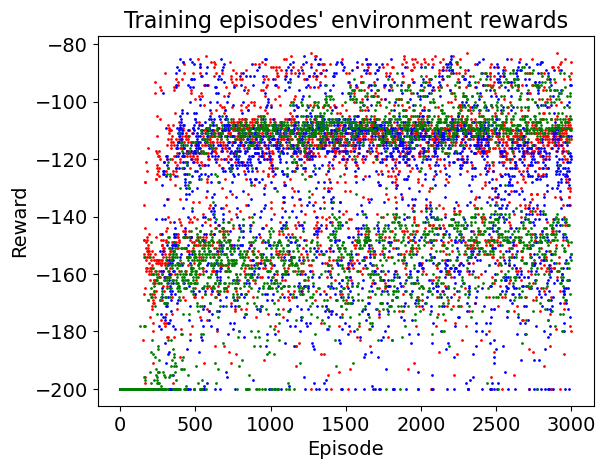

In [60]:
plt.scatter(range(n_episodes), env_rewards_heu, s=1, c='red', label="Environment reward", rasterized=True)
plt.scatter(range(n_episodes), env_rewards_RND, s=1, c='#0000ff', label="Heuristic reward", rasterized=True)
plt.scatter(range(n_episodes), env_rewards_Dyna, s=1, c='green', label="Total reward", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Training episodes' environment rewards", fontsize=16)
plt.savefig("plots/F_train_envReward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: training episodes' reward (average window)**

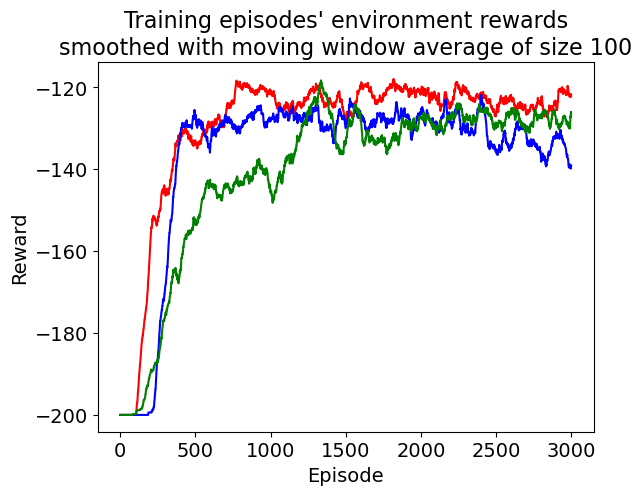

In [61]:
window_size = 100
plot_interval = 1
mask = [plot_interval*i for i in range(n_episodes//plot_interval)] + [n_episodes-1]

plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(env_rewards_heu, window_size)[mask], "-", c='red', label="DQN with heuristic reward", rasterized=True)
plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(env_rewards_RND, window_size)[mask], "-", c='#0000ff', label="DQN with RND reward", rasterized=True)
plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(env_rewards_Dyna, window_size)[mask], "-", c='green', label="Dyna", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title(f"Training episodes' environment rewards\nsmoothed with moving window average of size {window_size}", fontsize=16)
plt.savefig("plots/F_train_envReward_avg.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: training cumulative reward over episodes**

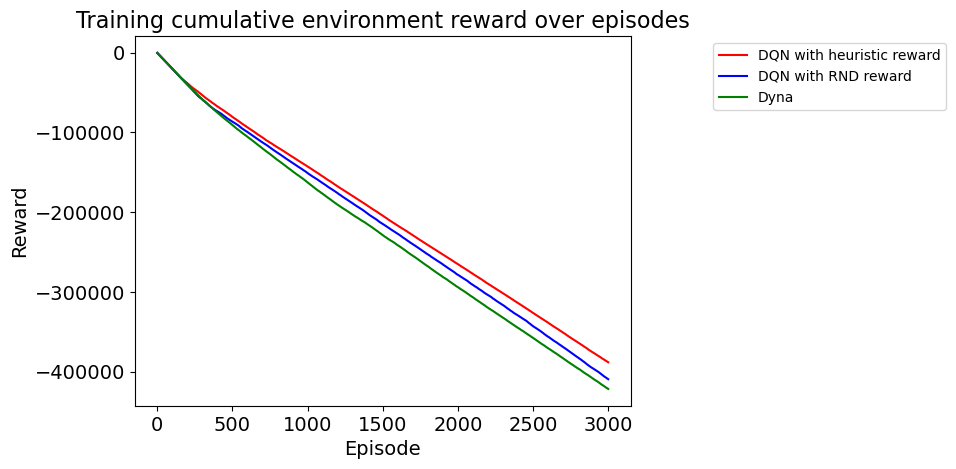

In [62]:
cum_rewards_heu = env_rewards_heu.cumsum()
cum_rewards_RND = env_rewards_RND.cumsum()
cum_rewards_Dyna = env_rewards_Dyna.cumsum()

plt.plot(range(n_episodes), cum_rewards_heu, '-', c='red', label="DQN with heuristic reward", rasterized=True)
plt.plot(range(n_episodes), cum_rewards_RND, '-', c='blue', label="DQN with RND reward", rasterized=True)
plt.plot(range(n_episodes), cum_rewards_Dyna, '-', c='green', label="Dyna", rasterized=True)
plt.ylabel("Reward", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Training cumulative environment reward over episodes", fontsize=16)
plt.legend(bbox_to_anchor=(1.65, 1), markerscale=3)
plt.savefig("plots/F_train_cumulativeEnvReward.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: testing duration w.r.t initial position**

In [63]:
df_heu_test = pd.read_csv('results/C_test_DQN_heuristic.csv')
df_RND_test = pd.read_csv('results/D_test_DQN_RND.csv')
df_Dyna_test = pd.read_csv('results/E_test_Dyna.csv')

n_episodes = len(df_heu_test.index)
initial_xs = df_heu_test.sort_values(by='initial_x')['initial_x'].to_numpy()

durations_heu = df_heu_test.sort_values(by='initial_x')['duration'].to_numpy()
durations_RND = df_RND_test.sort_values(by='initial_x')['duration'].to_numpy()
durations_Dyna = df_Dyna_test.sort_values(by='initial_x')['duration'].to_numpy()

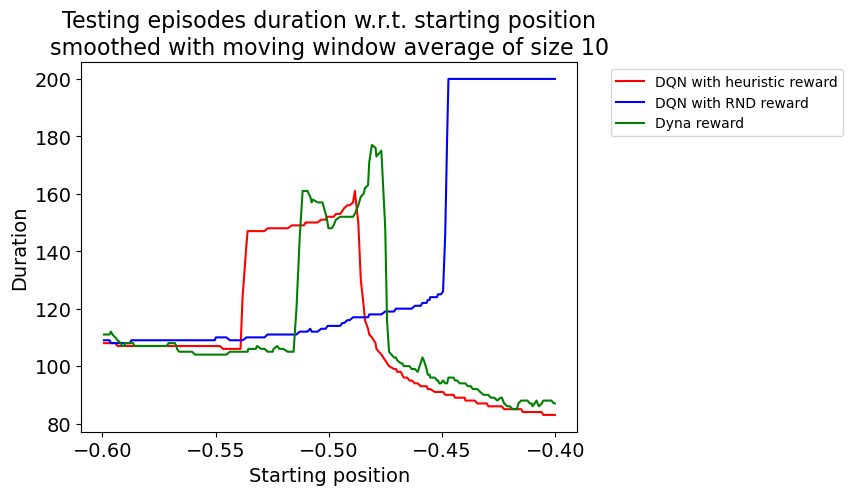

In [64]:
window_size = 10
plot_interval = 5
mask = [plot_interval*i for i in range(n_episodes//plot_interval)] + [n_episodes-1]

plt.plot(initial_xs[mask], moving_window_average(durations_heu, window_size)[mask], '-', c='red', label="DQN with heuristic reward", rasterized=True)
plt.plot(initial_xs[mask], moving_window_average(durations_RND, window_size)[mask], '-', c='blue', label="DQN with RND reward", rasterized=True)
plt.plot(initial_xs[mask], moving_window_average(durations_Dyna, window_size)[mask], '-', c='green', label="Dyna reward", rasterized=True)
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Starting position", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title(f"Testing episodes duration w.r.t. starting position\nsmoothed with moving window average of size {window_size}", fontsize=16)
plt.legend(bbox_to_anchor=(1.55, 1), markerscale=3)
plt.savefig("plots/F_test_duration.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: testing dutation over episodes (average window)**

In [65]:
df_heu_test = pd.read_csv('results/C_test_DQN_heuristic.csv')
df_RND_test = pd.read_csv('results/D_test_DQN_RND.csv')
df_Dyna_test = pd.read_csv('results/E_test_Dyna.csv')

n_episodes = len(df_heu_test.index)

durations_heu = df_heu_test['duration'].to_numpy()
durations_RND = df_RND_test['duration'].to_numpy()
durations_Dyna = df_Dyna_test['duration'].to_numpy()

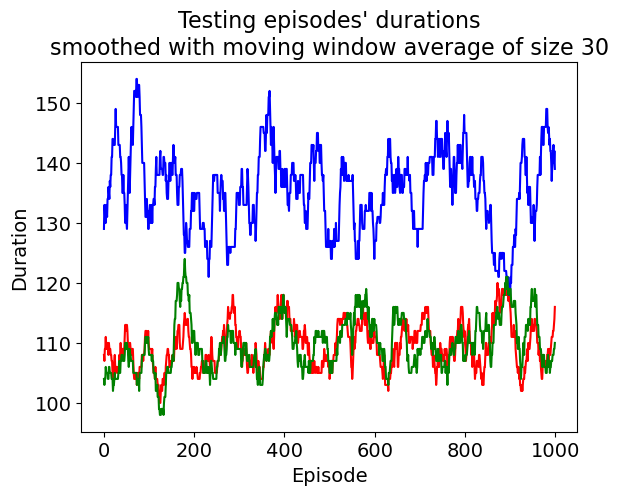

In [66]:
window_size = 30
plot_interval = 1
mask = [plot_interval*i for i in range(n_episodes//plot_interval)] + [n_episodes-1]

plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(durations_heu, window_size)[mask], "-", c='red', label="DQN with heuristic reward", rasterized=True)
plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(durations_RND, window_size)[mask], "-", c='#0000ff', label="DQN with RND reward", rasterized=True)
plt.plot(np.array(list(range(n_episodes)))[mask], moving_window_average(durations_Dyna, window_size)[mask], "-", c='green', label="Dyna", rasterized=True)
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title(f"Testing episodes' durations\nsmoothed with moving window average of size {window_size}", fontsize=16)
plt.savefig("plots/F_test_duration_avg.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()

**PLOT: testing cumulative dutation over episodes**

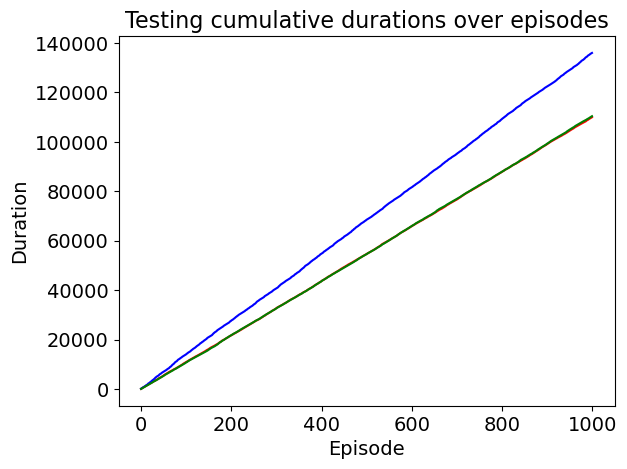

In [67]:
plt.plot(range(n_episodes), durations_heu.cumsum(), "-", c='red', label="DQN with heuristic reward", rasterized=True)
plt.plot(range(n_episodes), durations_RND.cumsum(), "-", c='#0000ff', label="DQN with RND reward", rasterized=True)
plt.plot(range(n_episodes), durations_Dyna.cumsum(), "-", c='green', label="Dyna", rasterized=True)
plt.ylabel("Duration", fontsize=14)
plt.xlabel("Episode", fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.title("Testing cumulative durations over episodes", fontsize=16)
plt.savefig("plots/F_test_cumulativeDuration.pdf", transparent=True, bbox_inches="tight", dpi=400)
plt.show()